## Kapcsolódás Google Drive-hoz

kadasgabor97@gmail.com


> 


Gaby512123K1

In [ ]:
from google.colab import drive # Ezzel tudunk kapcsolódni a Google Drive-hoz, ezzel elkerüljük azt, hogy a Colab felületére mindig fel kelljen töleni az adatainkat
import os #Az os package-vel tudunk mappákat kezelni (pl.: kiíratni milyen mappákat tartalmaz a gyökérkönyvtárunk)
drive.mount('/content/drive',force_remount=True)# Itt csatlakozik a Drive-hoz
os.chdir('/content/drive/My Drive/') #Itt választjuk ki a gyökér könyvtárat
os.listdir() # Kiirtjuk vele a 'Nuts' mappa tartalmát

Mounted at /content/drive


['Colab Notebooks',
 'nuts',
 'sample_image1.jpg',
 'sample_image2.jpg',
 'sample_image3.jpg',
 'sample_image4.jpg',
 'sample_image5.jpg',
 'sample_image6.jpg',
 'sample_image7.jpg',
 'sample_image8.jpg',
 'sample_image9.jpg',
 'sample_image10.jpg',
 'Nuts_dataset',
 'finalize_good_vs_bad',
 'good.20210925_11_38_48_Pro.jpg másolata',
 'finalize_good_vs_bad_test',
 'final_model.h5',
 'final',
 'final_model',
 'final_model.pb',
 'SavedModel.pb',
 'SavedModel',
 'model.png']

# Mappa rendezés

Eredeti mappánkban a jó (good.) és rossz (bad.) diók képei eggyüt szerepelnek, ezért ezt úgy fogjuk szétválogatni, hogy a jó és a rossz diók külön mappába kerülnek. Ezzel segítjük a programot és magunkat is, hogy a modell képes legyen egy 0 vagy 1 -es címkét rendelni az adatainkhoz

In [ ]:
# az adathalmaz rendezése megfelelő szerkezetbe
from os import makedirs
from os import listdir
from shutil import copyfile
# mappa létrehozás
dataset_home = 'finalize_good_vs_bad/'
# almappák létrehozása
labeldirs = ['good/', 'bad/']
for labldir in labeldirs:
	newdir = dataset_home + labldir
	makedirs(newdir, exist_ok=True)
# a tanító képek másolása a megfelelő almappákba
src_directory = 'Nuts_dataset/train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	if file.startswith('good'):
		dst = dataset_home + 'good/'  + file
		copyfile(src, dst)
	elif file.startswith('bad'):
		dst = dataset_home + 'bad/'  + file
		copyfile(src, dst)

# Model és tanítás

Az tanító halmaz 120 db romlott és 120 db nem romlott képet tartalmaz, melyek színesek, és 200 X 200 a felbontásuk. 

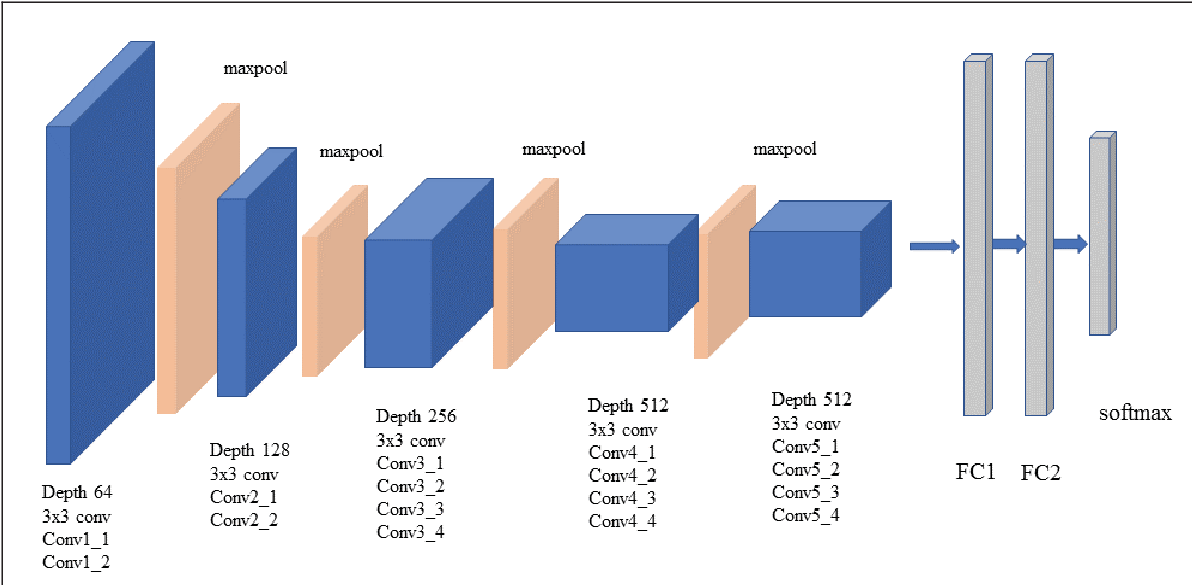

In [ ]:
# itt behívunk minden könyvtárat, amire szükségünk van
import tensorflow.compat.v1 as tf
# ezzel a kódrészlettel kikapcsoljuk a tensorflow 2 verzióját és az 1-eset fogjuk használni
tf.disable_v2_behavior()
# ezzel töltünk be egy előre definiált VGG16-os modellt
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
# ezzel olvassuk be a jpg fájlokat a modell számára értelmezhető tömbe, mivel kamara képet kap egy szerkezetből így ezt célszerű használni, nem pedig az előre legyártott tömböket
from keras.preprocessing.image import ImageDataGenerator 

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# konvolúciós hálózat definiálása
def define_model():
	
	model = VGG16(include_top=False, input_shape=(200, 200, 3))
	# a nem tanítható rétegek kidobásával csökken a tanítási paraméterek száma, ezzel gyorsabb lesz, és elkerülhetjük az általnosítási hibákat a modell futása során ()
	for layer in model.layers:
		layer.trainable = False
	# osztályozó réteg hozzáadása
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1) #relu azért lesz nekünk jó mert elkerüljük vele a vanishing gradient jelenséget
	output = Dense(1, activation='sigmoid')(class1) #aktivációs függvény:sigmoid
	model = Model(inputs=model.inputs, outputs=output)
	# modell összeállítása
	opt = SGD(lr=0.0001, momentum=0.9) #tanulási ráta, ez az optimális érték, próbálni kell, hogy mekkora érték a megfelelő, ennél nagyobb vagy kisebb érték rosszabb eredményt ad
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
	model.summary()
	return model

model = define_model()
	# adatgenerátor létrehozása
datagen = ImageDataGenerator(featurewise_center=True)
	# adja meg az imagenet átlagértékeit a központosításhoz
datagen.mean = [123.68, 116.779, 103.939]
	# iterátor előkészítése
train_it = datagen.flow_from_directory('finalize_good_vs_bad/',
	class_mode='binary', batch_size=16, target_size=(200, 200))
	# modell illesztése
model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=50, verbose=0)
	# modell lementése
model.save('SavedModel')

print('A tanulás sikeresen befejeződött, a modell mentése megtörtént!')

58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

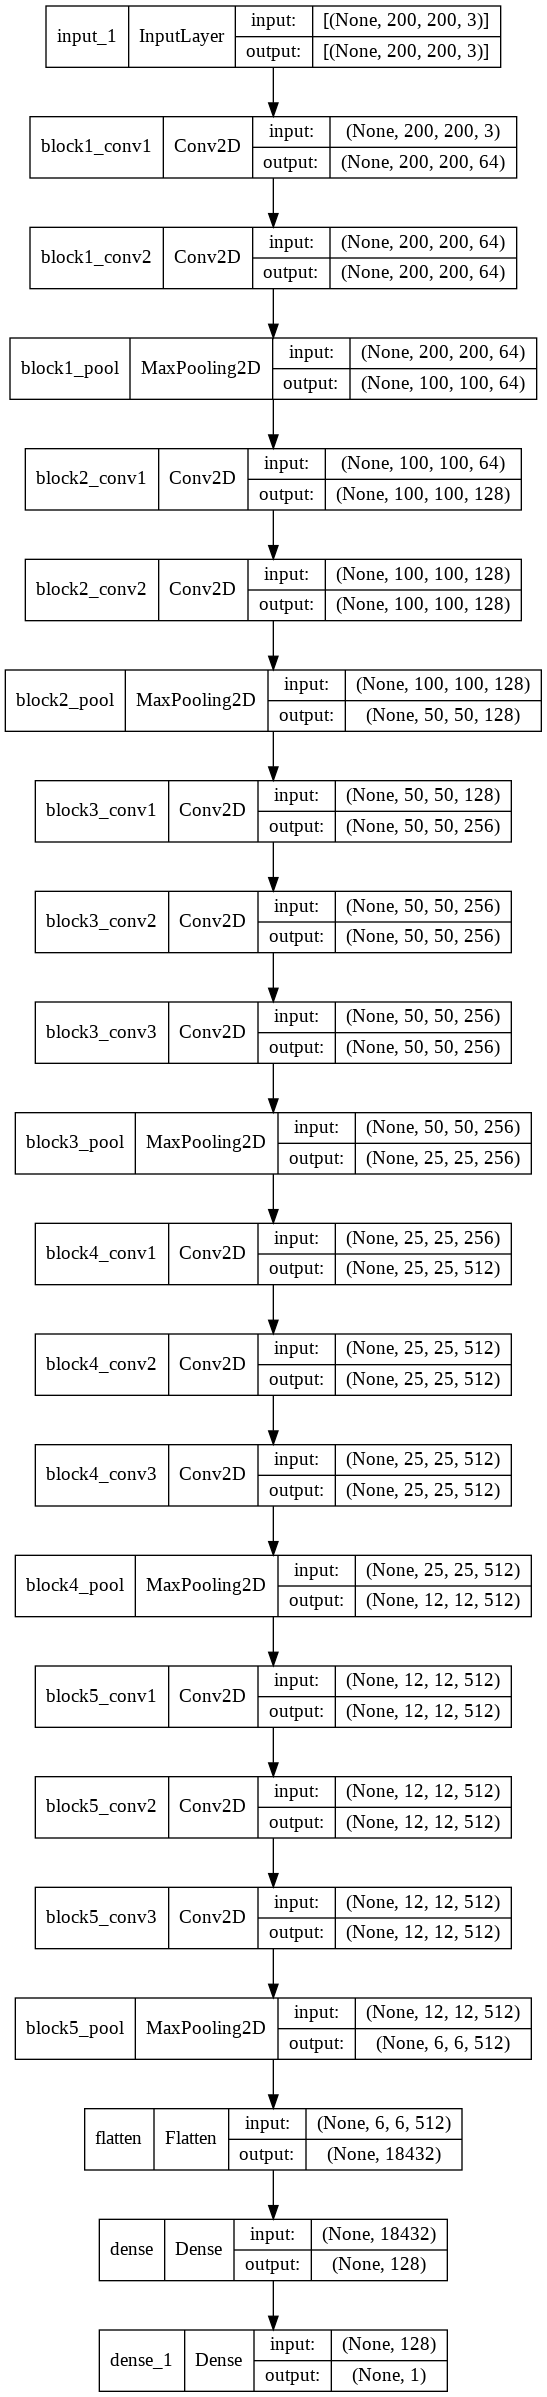

In [ ]:
from tensorflow.keras.utils import  plot_model
plot_model(model,to_file='model.png',show_shapes=True) 

In [ ]:
#import matplotlib.pyplot as plt
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('binary_crossentropy')
#plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
#plt.show()
#plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['accuracy'])
#plt.title('Modell accuracy')
#plt.ylabel('binary_crossentropy')
#plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
#plt.show()

NameError: ignored

A konkrét általunk használt modell

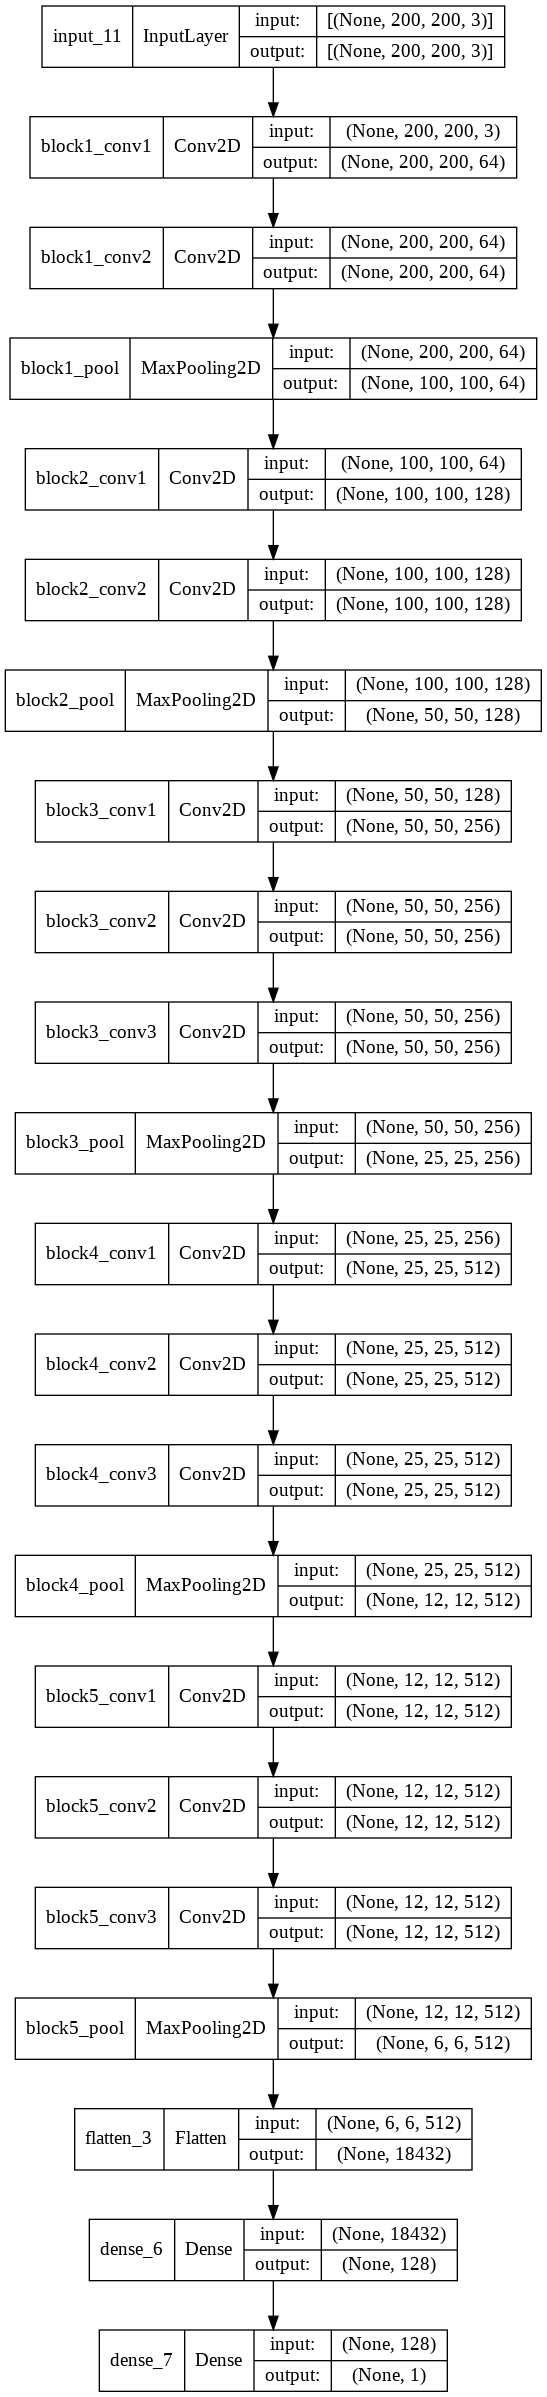

# Predikció teszthalmazok

Az teszt halmaz 51 db romlott és 22 db nem romlott képet tartalmaz, melyek színesek, és 200 X 200 a felbontásuk. Természetesen élehet egybe is vizsgálni a jókat és rosszakat de mivel nincs kiértékelés, így ha külön vizsgáljuk őket, könnyeben tudjuk vizsgálni, hogy mennyire pontos. Ha 50 %-nál nagyobb az érték akkor a dió jó, alatta pedig rossz.

51 romlott dióból 7-nél adott rossz választ.
22 nem romlott dióból 1-nél adott rossz választ.

Összesítve 89,04 % a pontossága a tanított modellünknek a teszt képeken.



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
A(z)0.dio:


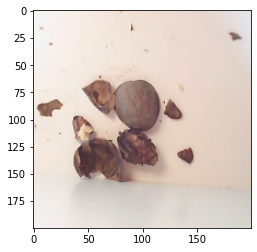

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[2.5373486e-06] %, hogy a dió nem romlott
A(z)1.dio:


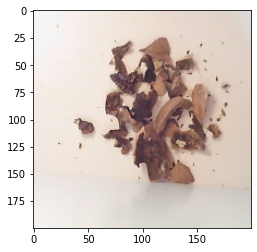

[99.999146] %, hogy a dió nem romlott
A(z)2.dio:


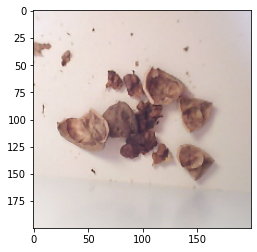

[7.8711724e-05] %, hogy a dió nem romlott
A(z)3.dio:


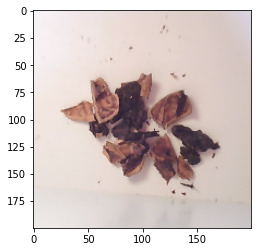

[0.86361223] %, hogy a dió nem romlott
A(z)4.dio:


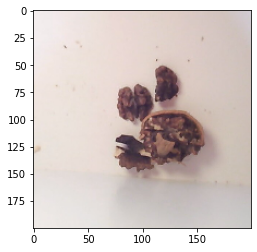

[2.7750896e-06] %, hogy a dió nem romlott
A(z)5.dio:


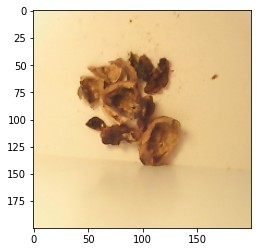

[56.81556] %, hogy a dió nem romlott
A(z)6.dio:


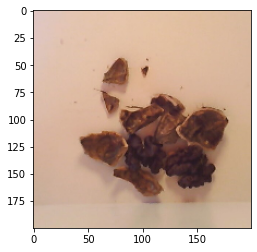

[1.5524134e-05] %, hogy a dió nem romlott
A(z)7.dio:


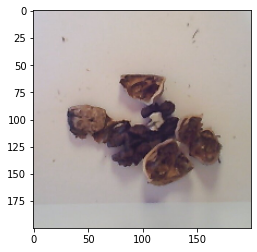

[7.3306037e-09] %, hogy a dió nem romlott
A(z)8.dio:


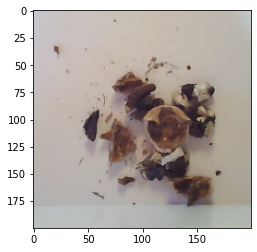

[5.416598e-06] %, hogy a dió nem romlott
A(z)9.dio:


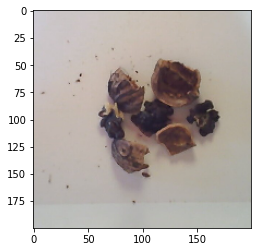

[6.333234e-11] %, hogy a dió nem romlott
A(z)10.dio:


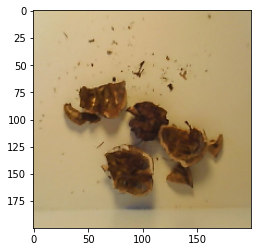

[0.0002648] %, hogy a dió nem romlott
A(z)11.dio:


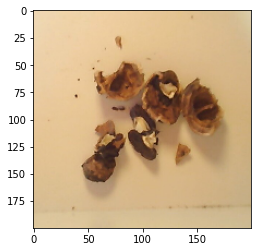

[3.9017267] %, hogy a dió nem romlott
A(z)12.dio:


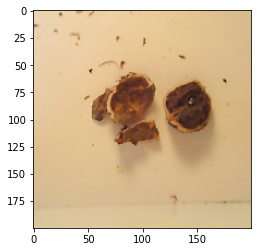

[4.4182458e-09] %, hogy a dió nem romlott
A(z)13.dio:


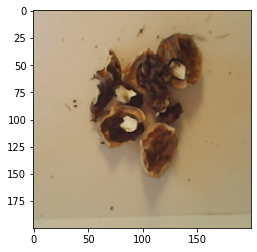

[0.18568231] %, hogy a dió nem romlott
A(z)14.dio:


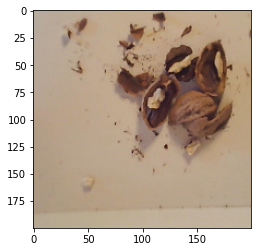

[8.715637e-06] %, hogy a dió nem romlott
A(z)15.dio:


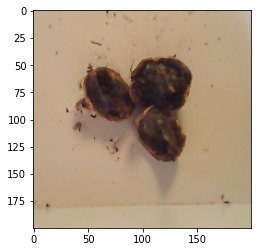

[3.241662e-06] %, hogy a dió nem romlott
A(z)16.dio:


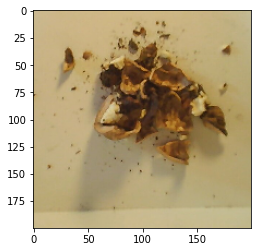

[99.46301] %, hogy a dió nem romlott
A(z)17.dio:


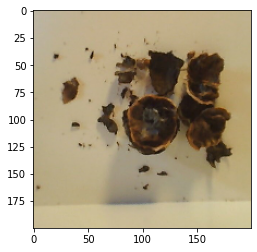

[1.9559352e-12] %, hogy a dió nem romlott
A(z)18.dio:


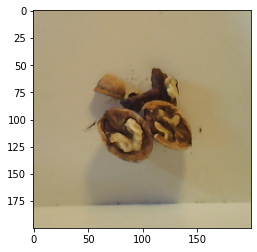

[4.9688697] %, hogy a dió nem romlott
A(z)19.dio:


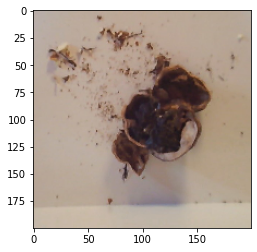

[2.4437898e-07] %, hogy a dió nem romlott
A(z)20.dio:


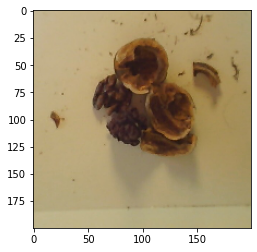

[0.2046341] %, hogy a dió nem romlott
A(z)21.dio:


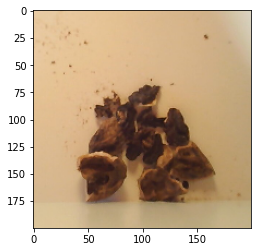

[18.862373] %, hogy a dió nem romlott


In [ ]:
# predikció a rossz diókra
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np


model = load_model('final_model')
# tesztképek betöltése
def load_image(filename):
	img = load_img(filename, target_size=(200, 200, 3))
	img2 = img #későbbi megjelenítésre kimentjük mert utana már floatra váltunk és az zavarja a matplotlibet
	# tömbé konvertálás
	img = img_to_array(img)
	# átformálja a képet
	img = img.reshape(1, 200, 200, 3)
	# center pixel adat
	img = img.astype('float32')
	img = img - [99.68, 92.779, 79.939]
	return img,img2
 
def run_example_bad():
	#a teszt mappa tartalmaz bad és good almappát mint a tanításnál
	for p in range (0,22):
		i = str(p)
		print('A(z)'+i+'.dio:')
		img,img2 = load_image('finalize_good_vs_bad_test/bad/'+ i +'sample_image.jpg')

		plt.imshow((img2)) 
		plt.show()
		
	# jósolja a besorolási osztályt
		result = model.predict(img)
		print(result[0]*100, '%, hogy a dió nem romlott')
 
run_example_bad()

In [ ]:
# predikció jó képekre
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


# model = load_model('final_model.h5') # csak akkor kell, ha külön nem futtatuk le az előzőbe, ilyenkor csak a ram-ot foglalja, ha ktészer beletesszük
 

def load_image(filename):

	img = load_img(filename, target_size=(200, 200))
	img2 = img
	img = img_to_array(img)
	img = img.reshape(1, 200, 200, 3)
	img = img.astype('float32')
	img = img - [99.68, 92.779, 79.939]
	return img,img2
 
	
def run_example_good():
	#a teszt mappa tartalmaz bad és good almappát mint a tanításnál
	for p in range (0,51):
		i = str(p)
		print('A(z)'+i+'.dio:')
		img,img2 = load_image('finalize_good_vs_bad_test/good/'+ i +'_sample_image.jpg')
		plt.imshow((img2)) 
		plt.show()
		
	# jósolja a besorolási osztályt
		result = model.predict(img)
		print(result[0]*100, '%, hogy a dió nem romlott')

run_example_good()

Output hidden; open in https://colab.research.google.com to view.